In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.8.0


In [5]:
base_dir = "C:/Users/hrith/Downloads/project/AlzheimerDataset/"
root_dir = "C:/Users/hrith/Downloads/project/"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [7]:
WORK_DIR = 'C:/Users/hrith/Downloads/project/dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [8]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


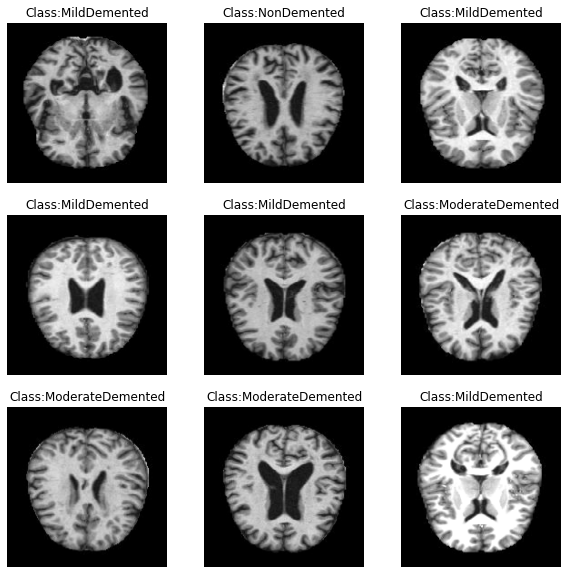

In [9]:
def show_images(generator,y_pred=None): 

    labels =dict(zip([0,1,2,3], CLASSES))

    x,y = generator.next()

    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

show_images(train_data_gen)

In [10]:
train_data, train_labels = train_data_gen.next()

In [11]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [12]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 5s 0us/step


In [15]:
for layer in inception_model.layers:
    layer.trainable=False

In [16]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [17]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [19]:
EPOCHS = 50

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 229s 874ms/step - loss: 1.3871 - acc: 0.4136 - auc: 0.6894 - f1_score: 0.4088 - val_loss: 0.8117 - val_acc: 0.6172 - val_auc: 0.8775 - val_f1_score: 0.5675 - lr: 0.0010
Epoch 2/50
256/256 [==============================] - 205s 800ms/step - loss: 0.9109 - acc: 0.5762 - auc: 0.8458 - f1_score: 0.5635 - val_loss: 0.6774 - val_acc: 0.6733 - val_auc: 0.9128 - val_f1_score: 0.6346 - lr: 0.0010
Epoch 3/50
256/256 [==============================] - 202s 789ms/step - loss: 0.7783 - acc: 0.6392 - auc: 0.8875 - f1_score: 0.6268 - val_loss: 0.6122 - val_acc: 0.7168 - val_auc: 0.9289 - val_f1_score: 0.7059 - lr: 0.0010
Epoch 4/50
256/256 [==============================] - 214s 835ms/step - loss: 0.7406 - acc: 0.6652 - auc: 0.9011 - f1_score: 0.6559 - val_loss: 0.5936 - val_acc: 0.7173 - val_auc: 0.9313 - val_f1_score: 0.7072 - lr: 0.0010
Epoch 5/50
256/256 [==============================] - 192s 750ms/step - loss: 0.6937 - acc: 0.6906 - auc: 0.

### Tabulating the Results of our custom InceptionV3 model

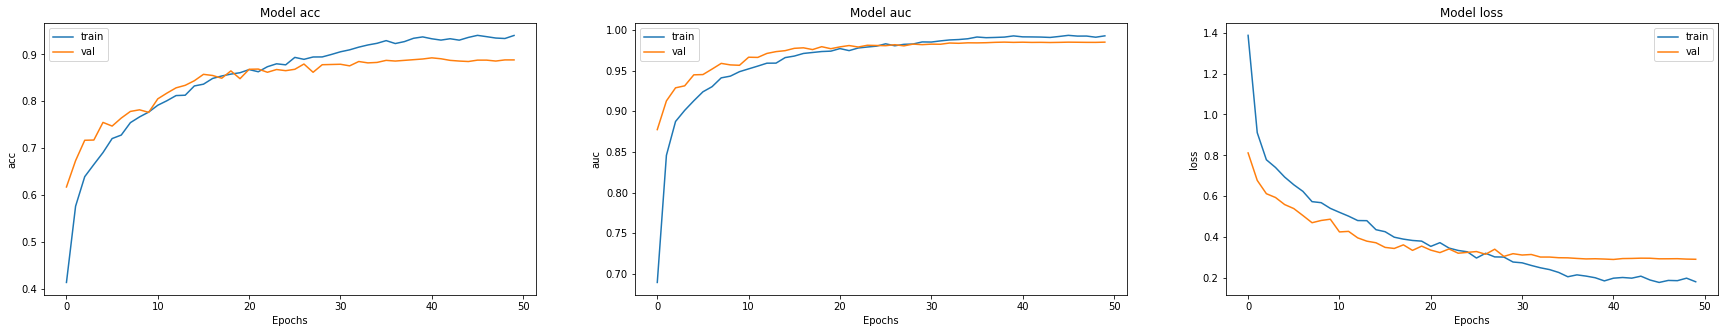

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [22]:
test_scores = custom_inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 53s 651ms/step - loss: 0.3089 - acc: 0.8883 - auc: 0.9841 - f1_score: 0.8886
Testing Accuracy: 88.83%


In [23]:
pred_labels = custom_inception_model.predict(test_data)

In [24]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.92      0.94      0.93       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.88      0.77      0.82       662
ModerateDemented       0.76      0.85      0.80       624

       micro avg       0.89      0.89      0.89      2560
       macro avg       0.89      0.89      0.89      2560
    weighted avg       0.89      0.89      0.89      2560
     samples avg       0.89      0.89      0.89      2560



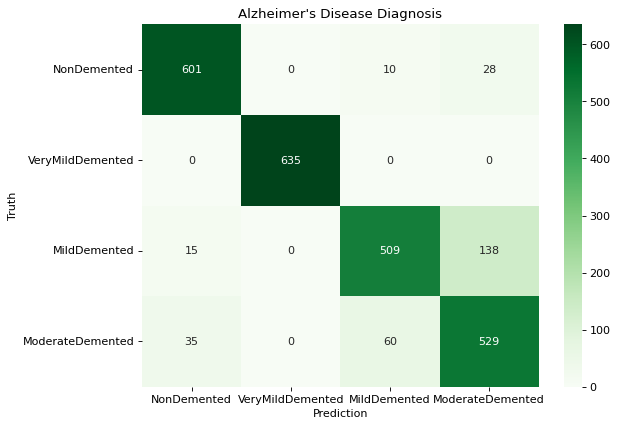

In [25]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [26]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 88.93 %
Matthew's Correlation Coefficient: 85.22 %


In [27]:
custom_inception_model_dir = work_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_inception_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [28]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)

plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
